In [1]:
import numpy as np
import psi4
from matplotlib import pyplot as plt


In [76]:
# fonction calcul X=Us^-1/2U^dagger à partir de matrice overlap S, une matrice overlap n'a que des
# valeurs propres strictement positives (définie positive), donc pas de problèmes pour calculer s=np.diag(1/np.sqrt(evalues))

    
def verif_X_matrix(X,S):
    Xh=np.conjugate(X.T)
    n=len(X)
    verif=np.matmul(Xh,np.matmul(S,X))
    if (abs(verif-np.identity(n))<(10**-10)).all():
        return True
    else:
        return(False)
##
def X_matrix(S):
    evalues,U= np.linalg.eigh(S) #S=U*evalues*Udagger
    s=np.diag(1/np.sqrt(evalues))#matrice diagonale avec l'inverse des racines des valeurs propres

    X=np.matmul(np.matmul(U,s),np.conjugate(U.T)) #X=Us^(-1/2)U*
    #X=np.matmul(U,s) #X=Us^(-1/2)
    
    if verif_X_matrix(X,S):
        return(X)
    else: 
        print('problem with X')
        return

In [77]:
#Calcul de F a l'aide de la matrice densité F= H + G
def G_matrix(P,v):
    n=len(P)
    G=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    G[i,j]+=P[k,l]*(v[i][j][k][l]-0.5*v[i][l][k][j])
    return(G)
#  
#fonction calcul  F'=X*FX

def new_fock_matrix(F,X):
    FX=np.matmul(F,X)
    return(np.matmul(np.conjugate(X.T),FX))
##

In [78]:
#calcul matrice C=XC' des coefs

def coef_matrix(f,X):
    energy,c = np.linalg.eigh(f)
    C = np.matmul(X,c)
    return(C)


In [79]:
def new_density_matrix(C,Bas_n,N):
    P=np.zeros_like(C)
    for i in range(Bas_n):
        for j in range(Bas_n):
            for a in range(int(N/2)):
                P[i,j]+=2*C[i,a]*C[j,a]
    return(P)


In [80]:
#convergence de l'algo avec le commutateur

def convergence(F,P,S,lim):
    FPS=np.matmul(F,np.matmul(P,S))
    SPF=np.matmul(S,np.matmul(P,F))
    if (abs(FPS-SPF)<=lim).all():
        return True
    else:
        return False
    

    

In [81]:
def SCF_energy(S,v,H,Bas_n,N,lim,max_iter):
    #initialisation
    X=X_matrix(S)
    P=np.zeros((Bas_n,Bas_n))

    New_Energy=0
    Old_Energy=0
    
    Enn=mol.nuclear_repulsion_energy()
    
    #Boucle convergence
    F=H
    for n_iter in range(max_iter):


        
        #Calcul de la nouvelle matrice densité
        f=new_fock_matrix(F,X)
        C=coef_matrix(f,X)
        P=new_density_matrix(C,Bas_n,N)
        
        #Matrice de Fock
        G=G_matrix(P,v)
        F=H+G
        
        #Calcul de l'énergie
        Old_Energy=New_Energy 
        New_Energy=0.5*np.trace(np.matmul(P,H+F))
        
        #Condition de convergence
        
        if n_iter!=0 and (abs(New_Energy-Old_Energy)<lim):
            print('Converged after', n_iter,'iterations')
            return(New_Energy+Enn)
    print('Did not converge')
    return(New_Energy+Enn)



def SCF_energy_commutator(S,v,H,Bas_n,N,lim,max_iter):
    #initialisation
    X=X_matrix(S)
    P=np.zeros((Bas_n,Bas_n))
    Enn=mol.nuclear_repulsion_energy()
    
    #Boucle convergence
    F=H
    for n_iter in range(max_iter):


        
        #Calcul de la nouvelle matrice densité
        f=new_fock_matrix(F,X)
        C=coef_matrix(f,X)
        P=new_density_matrix(C,Bas_n,N)
        
        #Matrice de Fock
        G=G_matrix(P,v)
        F=H+G

        #Condition de convergence
        
        if n_iter!=0 and convergence(F,P,S,lim):
            print('Converged after', n_iter,'iterations')
            return(0.5*np.trace(np.matmul(P,H+F))+Enn)
        
    print('Did not converge')
    return(0.5*np.trace(np.matmul(P,H+F))+Enn)

In [85]:
psi4.set_memory('500 MB')
#liste de distance et listes pour les énergies
Dist_list=np.linspace(0.1,8,num=100)
Energy_list=[]
Energy_list2=[]

n=0
for Dist in Dist_list:
    # géométrie de la molécule
    mol = psi4.geometry("""
    H  0.0 0.0 0.0 
    H  0.0 """+str(Dist)+""" 0.0

    """)
    

    geo_unit = psi4.core.GeometryUnits(0) # Angstrom:0 , bohr:1
    null=psi4.core.Molecule.set_units(mol,geo_unit)
    null=psi4.core.Molecule.set_molecular_charge(mol,0)
    null=psi4.core.Molecule.set_multiplicity(mol,1)
    
    #Fonction d'onde de la molécule
    wf = psi4.core.Wavefunction.build(mol,basis='cc-pvdz')
    mints = psi4.core.MintsHelper(wf.basisset())

    #différentes intégrales calculées par psi4
    S = np.asarray(mints.ao_overlap())
    v = np.asarray(mints.ao_eri())
    T = np.asarray(mints.ao_kinetic())
    V = np.asarray(mints.ao_potential())
    H=T+V
    
    #Différents paramètres pour l'algo
    Bas_n = S.shape[0] #shape(H)=(Bas_n,Bas_n)
    N= int(2*wf.nalpha())
    lim=10**(-7)
    max_iter=100

    #calcul des énergies en Ha

    Energy=SCF_energy(S,v,H,Bas_n,N,lim,max_iter)
    Energypsi4=psi4.energy('hf/cc-pvdz')
    Energy_list.append(Energy)
    Energy_list2.append(Energypsi4)

Converged after 6 iterations
Converged after 6 iterations
Converged after 6 iterations
Converged after 6 iterations
Converged after 6 iterations
Converged after 6 iterations
Converged after 6 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged after 5 iterations
Converged afte

[6.59875702e-06 5.07253225e-06 4.28707481e-06 3.80125413e-06
 3.20985000e-06 2.52277668e-06 1.86793943e-06 1.33056922e-06
 9.48613836e-07 7.47927793e-07 7.25945729e-07 8.80384234e-07
 1.24322066e-06 1.87215063e-06 2.77899520e-06 3.84974788e-06
 4.85106356e-06 5.55710204e-06 5.90134020e-06 6.01842822e-06
 6.15304089e-06 6.52766287e-06 7.26074202e-06 8.35893293e-06
 9.75716521e-06 1.13704861e-05 1.31335942e-05 1.50187350e-05
 1.70327779e-05 1.91996808e-05 2.15366886e-05 2.40324956e-05
 2.66337317e-05 2.92430431e-05 3.17285717e-05 3.39417386e-05
 3.57385964e-05 3.69998705e-05 3.76458819e-05 3.76442877e-05
 3.70104096e-05 3.58013178e-05 3.41057212e-05 3.20319188e-05
 2.96958351e-05 2.72106354e-05 2.46787957e-05 2.21869331e-05
 1.98032523e-05 1.75771814e-05 1.55406320e-05 1.37103033e-05
 1.20905129e-05 1.06761458e-05 9.45542813e-06 8.41234995e-06
 7.52864936e-06 6.78534286e-06 6.16383162e-06 5.64664108e-06
 5.21786200e-06 4.86336230e-06 4.57083300e-06 4.33140449e-06
 4.13269567e-06 3.968998

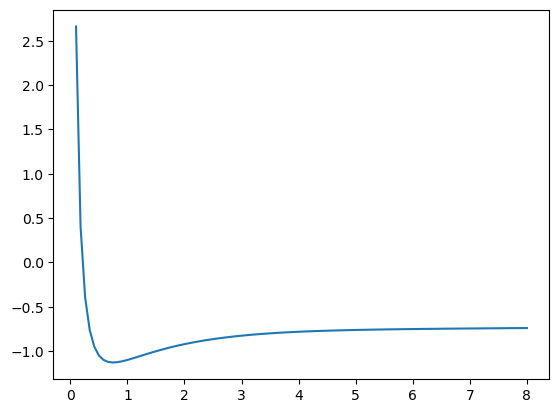

In [86]:
plt.plot(Dist_list, np.asarray(Energy_list))
print(np.asarray(Energy_list)-np.asarray(Energy_list2))

[-4.27320758e-05 -3.66859004e-05 -3.54227975e-05 -3.46537891e-05
 -3.20528185e-05 -2.81003387e-05 -2.82762080e-05 -2.25398190e-05
 -1.83580853e-05 -1.58052418e-05 -1.72943423e-05 -1.98459171e-05
 -2.25603721e-05 -2.43233976e-05 -2.40828324e-05 -2.40828312e-05
 -2.43233964e-05 -2.25603741e-05 -1.98459159e-05 -1.72943445e-05
 -1.58052426e-05 -1.83580870e-05 -2.25398206e-05 -2.82762084e-05
 -2.81003370e-05 -3.20528199e-05 -3.46537892e-05 -3.54227993e-05
 -3.66859008e-05 -4.27320746e-05]


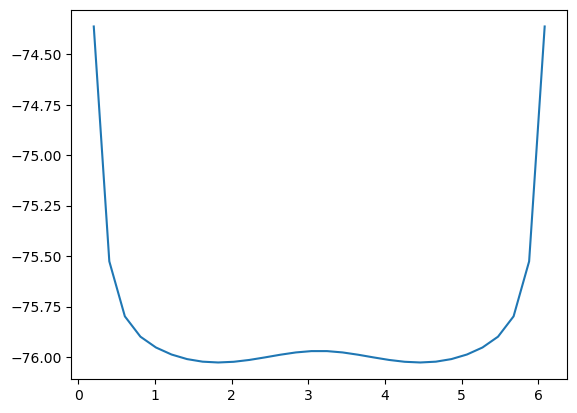

In [21]:
plt.plot(Angl_list, np.asarray(Energy_list))
print(np.asarray(Energy_list)-np.asarray(Energy_list2))